In [1]:
import hylite
from hylite import io
import matplotlib.pyplot as plt
import numpy as np

In [5]:
%matplotlib inline

### 1. Classification approaches

Many (but not all) hyperspectral mapping tasks revolve around classification of e.g. lithology or metallurgical domains. Machine learning approaches can be applied to perform supervised and unsupervised classifications (these will be discussed tomorrow), but knowledge-based classifications can also be created using a decision tree. These can quickly become impractically complex, but for simple problems have the advantage that the results (and limitations thereof) are easy to understand. 

In the following we will build on the spectral features defined in the previous notebooks to classify sericitic and chloritic alteration at Corte Atalaya. Lets begin by loading the datasets:

In [6]:
# load datasets to play with
image = io.load( 'test_data/image.hdr' )
cloud = io.load( 'test_data/hypercloud.ply' )

And then recalculating AlOH and FeOH indices that correlate with sericite / chlorite abundance respectively:

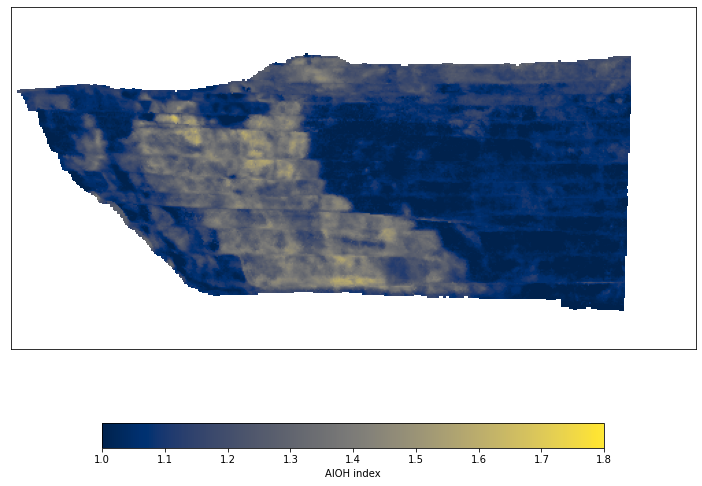

In [7]:
# AlOH index
from hylite.analyse import band_ratio
AlOH = band_ratio( cloud, 2110., 2200.) # band ratio = 2075 nm / 2200 nm
fig,ax = AlOH.quick_plot(0, cloud.header.get_camera(0),cmap='cividis', 
                      fill_holes=True, vmin=1.0, vmax=1.8)
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("AlOH index")
fig.show()

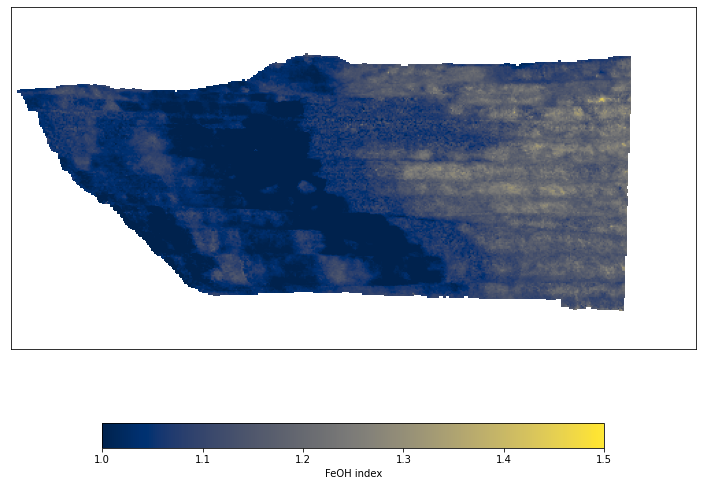

In [8]:
# FeOH index
from hylite.analyse import band_ratio
FeOH = band_ratio( cloud, 2235., 2260.) # band ratio = 2075 nm / 2200 nm
fig,ax = FeOH.quick_plot(0, cloud.header.get_camera(0), cmap='cividis', 
                      fill_holes=True, vmin=1.0, vmax=1.5)
cbar = fig.colorbar( ax.cbar, orientation='horizontal', shrink=0.5)
cbar.set_label("FeOH index")
fig.show()

### Decision trees

Decision trees filter points / pixels based on a set of specific layers to determine class labels (which represent the leaves of the tree). For example, a conceptual tree can be built based on the above band ratios to distinguish chloritic and sericitic alteration:

                        input 
                      /       \
                     /         \
    AlOH index:    low         high
                   /  \        /   \ 
    FeOH index:  low   high   low   high
                  |     |      |      |
        Result: unalt. chl    ser    chl+ser
                   
Note that this is a binary tree (each layer of the tree is based on a binary decision). Highlight has a function to help construct and classify data using such binary trees. The first step is to decide on the thresholds that determine the difference between low and high. We can do this by creating some histograms:

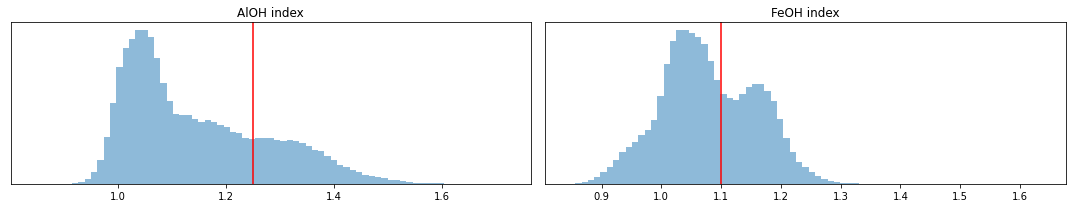

In [9]:
fig,ax = plt.subplots(1,2,figsize=(15,3)) # create matplotlib figure

# generate AlOH histogram
ax[0].hist( AlOH.data.ravel(), bins=75, alpha=0.5 ) # plot histogram
ax[0].set_title("AlOH index") # add title
ax[0].axvline(1.25, color='r') # add vertical line showing proposed threshold
ax[0].set_yticks([]) # remove vertical ticks

# generate FeOH histogram
ax[1].hist( FeOH.data.ravel(), bins=75, alpha=0.5 )
ax[1].set_title("FeOH index")
ax[1].axvline(1.1, color='r')
ax[1].set_yticks([])
fig.tight_layout()
fig.show()

These results suggest that 1.25 and 1.1 are good thresholds for determining the presence/absense of significant AlOH and FeOH features respectively (for this dataset). Based on this we create boolean layers (containing True or False for each pixel) using numpy:

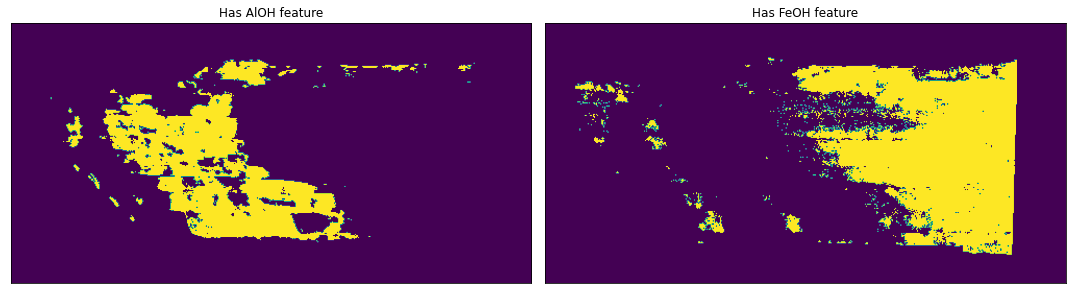

In [11]:
hasAlOH = AlOH.data[..., 0] > 1.25 # True if AlOH feature is present
hasFeOH = FeOH.data[..., 0] > 1.1 # True if AlOH feature is present

# plot these boolean layers
fig,ax = plt.subplots(1,2,figsize=(15,5))
hylite.HyCloud( cloud.xyz, bands=hasAlOH[..., None] ).quick_plot( 0, cloud.header.get_camera(0), 
                                                                 fill_holes=True, ax=ax[0] )
hylite.HyCloud( cloud.xyz, bands=hasFeOH[..., None] ).quick_plot( 0, cloud.header.get_camera(0), 
                                                                  fill_holes=True, ax=ax[1] )

# do some housekeeping
for a in ax:
    a.set_xticks([])
    a.set_yticks([])
ax[0].set_title("Has AlOH feature")
ax[1].set_title("Has FeOH feature")

fig.tight_layout()
fig.show()

Now we just need to combine these layers to come up with a class label. Hylite has a `decision_tree` function that can help us do this.

In [12]:
from hylite.analyse import decision_tree

In [13]:
decision_tree?

In [14]:
layers = [hasAlOH, hasFeOH] # define the layers of our tree
labels = {(False,   False) : "Unaltered", # give leaves of the tree names
          (True,    False) :  "Sericite",
          (False,   True) :  "Chlorite",
          (True,    True) :   "Chl+Ser",
         }

# apply this decision tree to dataset
clf, lab = decision_tree( layers, labels )

# and bind it to a new HyCloud instance
clf = hylite.HyCloud( cloud.xyz, bands=clf[...,None] )

Using a few matplotlib tricks we can plot this as a pretty map!

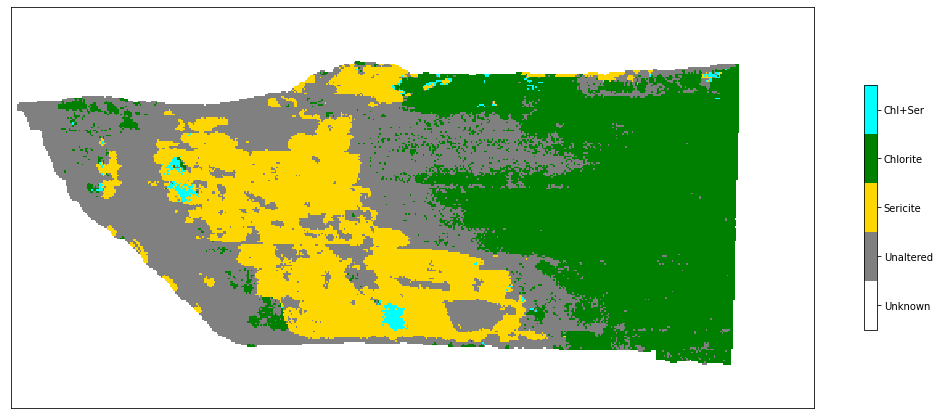

In [18]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(['white','gray','gold','green','cyan' ] )#note that the 'unknown' class is automatically added
fig,ax = clf.quick_plot( 0, cloud.header.get_camera(0), cmap=cmap, vmin=-0.5, vmax=4.5, 
                        fill_holes=True, interpolation = 'nearest' )
cm = fig.colorbar(ax.cbar, shrink=0.5)
cm.ax.set_yticklabels(lab)
ax.set_xticks([])
ax.set_yticks([])
fig.show()

And there's a quick and dirty geology map! You can see these results (using a slightly expanded decision tree) in 3-D here: https://tinyurl.com/ca-hypercloud. Further details can also be found in our publication at https://doi.org/10.1016/j.oregeorev.2021.104252.

----
**Exercise**: *Implement and apply this decision tree for the hand sample image also. Do the classification results make sense also for these laboratory scans? Or are different thresholds needed? Discuss.*

---

In [63]:
 # add your funky code here!

----
**Advanced Exercise**: *How sensitive is this classification to the thresholds chosen for each layer? Could there be better values? Could you vary these somehow to quantify classification uncertainty?*

---

In [ ]:
 # add your funky code here!